## Solution for yandex machine learning iprofi competition 2021

В реальной жизни для изучения свойств целевого пласта на месторождении бурятся скважины, после чего в них опускаются специальные устройства - каротажные зонды. С их помощью проводится запись различных геофизических полей (например, радиоактивность или плотность), создаваемых горными породами. Подобные исследования называются геофизическими исследования скважин - ГИС. На основе полученных данных специалисты петрофизики проводят интерпретацию и сообщают информацию о том, на какой глубине находится пласт-коллектор, который может накапливать и отдавать флюиды. Типичный пример различных каротажных кривых и их совместной интерпретации представлен на рисунке ниже:



![](https://drive.google.com/uc?export=view&id=1Q34wnQ0BQyb6saB3eVlPrlnATiIJGPmu)



На основе полученной интерпретации можно посчитать такое свойство как песчанистость в зоне бурения скважины. Песчанистость — это отношение толщин пластов-коллекторов к общей толщине геологического образования, данная характеристика позволяет геологам делать предположения об экономической эффективности работы с этим месторождением. К сожалению, бурение скважин является очень дорогостоящей операцией, поэтому мы используем различные алгоритмы картопостроения с целью прогноза свойств в межскважинном пространстве. В качестве данных в представленной задаче используется информация из синтетической модели месторождения, которая была построена на основе геологического обнажения Шестаково, Кемеровская область. По его описанию были определены различные геологические параметры (размеры и геометрия тел, их связанность и значение песчанистости), которые в дальнейшем использовались при построении 3D модели. Подобный подход позволил достаточно точно отобразить реальную геологию (которая обычно не доступна для визуального анализа) и использовать полученный результат в качестве полигона для опробования и оценки различных подходов.



![](https://drive.google.com/uc?export=view&id=1696Z1bUaT-0xtRC6Bp02YZcwmy2FTXpx)



В предоставленном наборе данных имеется информация о 10% скважинных данных (в реальной жизни их может быть менее 1% от площади месторождения!), используя которые, Вам предлагается построить алгоритм, который бы предсказывал значения песчанистости в точках с отсутствующими значениями.

**Вход:** тренировочный датасет (Training wells.csv) с заполненными значениями песчанистости, а также тестовый датасет (Empty part.csv) с пропущенными значениями песчанистости, для которого вы должны предсказать эти значения. https://disk.yandex.ru/d/M6J9r7yvR8m3GQ?w=1.

**Выход:** файл с предсказанием песчанитости для тестового файла. В выходном файле последовательность строк сохранить, само предсказание песчанистости добавить четвёртым столбцом в датасет с заголовком столбца NTG, как это сделано в тренировочном датасете. Получившийся файл загрузить в систему.

**Критерии оценивания:** в качестве метрики оценивания используется метрика RMSE, участники ранжируются относительно значения этой метрики (от меньшего к большему).

За каждую отправку вы не будете видеть балл во избежание подгона под ответ, но будете видеть статус отправки (если всё хорошо - ОК, если проблемы с файлом - WA). Затем по итогу всех отправок будет засчитана лучшая попытка.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor, plot_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

from yellowbrick.cluster import KElbowVisualizer

In [2]:
data_path = 'data'
submission_path = 'submission'

In [3]:
train = pd.read_csv(os.path.join(data_path, 'Training_wells.csv'))
test = pd.read_csv(os.path.join(data_path, 'Empty_part.csv'))

## Features generation

In [4]:
x_not_in_train = []
y_not_in_train = []
for x, y in zip(test.X, test.Y):
    if x not in train.X.values and x not in x_not_in_train:
        x_not_in_train.append(x)
    if y not in train.Y.values and y not in y_not_in_train:
        y_not_in_train.append(y)
        
print('X not in train: {}'.format(x_not_in_train))
print('Y not in train: {}'.format(y_not_in_train))

X not in train: [213, 233, 236]
Y not in train: []


<AxesSubplot:xlabel='X', ylabel='Y'>

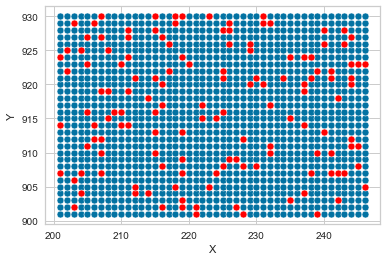

In [5]:
sns.scatterplot(data=test, x='X', y='Y')
sns.scatterplot(data=train, x='X', y='Y', color='red')

<AxesSubplot:xlabel='X', ylabel='Y'>

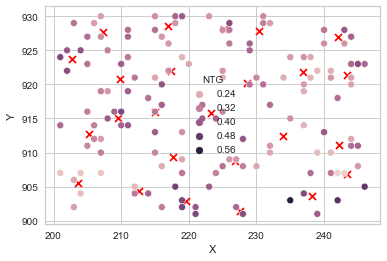

In [6]:
from sklearn.cluster import KMeans

kmeans_train = KMeans(n_clusters=25, random_state=42)
kmeans_train.fit(train[['X', 'Y']])

plt.scatter(kmeans_train.cluster_centers_[:, 0], kmeans_train.cluster_centers_[:, 1], marker='x', color='red')
sns.scatterplot(data=train, x='X', y='Y', hue='NTG')

<AxesSubplot:xlabel='X', ylabel='Y'>

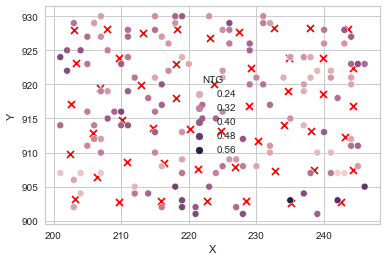

In [7]:
df = pd.concat([train[['X', 'Y']], test[['X', 'Y']]], axis=0)

kmeans_all = KMeans(n_clusters=50, random_state=42)
kmeans_all.fit(df)

plt.scatter(kmeans_all.cluster_centers_[:, 0], kmeans_all.cluster_centers_[:, 1], marker='x', color='red')
sns.scatterplot(data=train, x='X', y='Y', hue='NTG')

In [8]:
columns = ['X', 'Y', 'cluster_train', 'cluster_all']
agg_types = ['mean', 'min', 'max']

def generate_grouped_features(train, test):

    train_copy = train.copy()
    test_copy = test.copy()
    
    for column in columns:
        for agg_type in agg_types:
            group = train_copy.groupby(by=column).agg({'NTG':agg_type})
            group.reset_index(inplace=True)
            group.columns = [column, 'NTG_{}_{}'.format(column, agg_type)]
            
            train_copy = pd.merge(train_copy, group, on=column, how='left')
            test_copy = pd.merge(test_copy, group, on=column, how='left')
            
    return train_copy, test_copy

In [9]:
train['cluster_train'] = kmeans_train.labels_[:train.shape[0]]
train['cluster_all'] = kmeans_all.labels_[:train.shape[0]]

test_copy = test.copy()
test_copy['cluster_train'] = kmeans_train.predict(test[['X', 'Y']])
test_copy['cluster_all'] = kmeans_all.labels_[train.shape[0]:]

train_gen, test_gen = generate_grouped_features(train, test_copy)
assert train_gen.shape[1] == (len(columns) * len(agg_types) + train.shape[1])

### Generated feature test & modeling

In [10]:
def cross_valid_score(estimator, X, y, cv=5, shuffle=True, random_state=42):
    
    kfold = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)

    scores = []

    for train_index, test_index in kfold.split(X):   
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = estimator
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        
    return np.array(scores)

In [11]:
X, y = train_gen.drop(['Well', 'NTG'], axis=1), train_gen['NTG']

In [12]:
features = ['X', 'Y']

xgb_reg = XGBRegressor(objective='reg:squarederror')
lin_reg = LinearRegression()

xgb_score = cross_valid_score(xgb_reg, X[features], y)
lr_score = cross_valid_score(lin_reg, X[features], y)

print(f'Mean XGB cross_score: {xgb_score.mean()}')
print(f'Mean LR cross_score: {lr_score.mean()}')

Mean XGB cross_score: 0.06040353211639712
Mean LR cross_score: 0.07233797461214798


In [13]:
features = ['X', 'Y', 'cluster_train']

xgb_reg = XGBRegressor(objective='reg:squarederror')
lin_reg = LinearRegression()

xgb_score = cross_valid_score(xgb_reg, X[features], y)
lr_score = cross_valid_score(lin_reg, X[features], y)

print(f'Mean XGB cross_score: {xgb_score.mean()}')
print(f'Mean LR cross_score: {lr_score.mean()}')

Mean XGB cross_score: 0.057842180376976214
Mean LR cross_score: 0.06564932745146249


In [16]:
features = ['X', 'Y', 'cluster_all']

xgb_reg = XGBRegressor(objective='reg:squarederror')
lin_reg = LinearRegression()

xgb_score = cross_valid_score(xgb_reg, X[features], y)
lr_score = cross_valid_score(lin_reg, X[features], y)

print(f'Mean XGB cross_score: {xgb_score.mean()}')
print(f'Mean LR cross_score: {lr_score.mean()}')

Mean XGB cross_score: 0.0576858593784933
Mean LR cross_score: 0.07260095842358319


In [17]:
features = ['X', 'Y', 'cluster_train', 'cluster_all']

xgb_reg = XGBRegressor(objective='reg:squarederror')
lin_reg = LinearRegression()

xgb_score = cross_valid_score(xgb_reg, X[features], y)
lr_score = cross_valid_score(lin_reg, X[features], y)

print(f'Mean XGB cross_score: {xgb_score.mean()}')
print(f'Mean LR cross_score: {lr_score.mean()}')

Mean XGB cross_score: 0.05912612195389072
Mean LR cross_score: 0.06618486330164391


In [18]:
xgb_reg = XGBRegressor(objective='reg:squarederror')
lin_reg = LinearRegression()

xgb_score = cross_valid_score(xgb_reg, X, y)
lr_score = cross_valid_score(lin_reg, X, y)

print(f'Mean XGB cross_score: {xgb_score.mean()}')
print(f'Mean LR cross_score: {lr_score.mean()}')

Mean XGB cross_score: 0.05001018865344962
Mean LR cross_score: 0.04405135168365143


### Feature selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

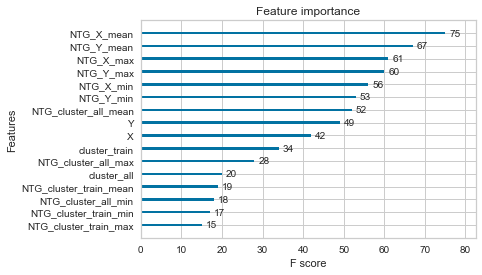

In [19]:
xgb_reg = XGBRegressor(objective='reg:squarederror')
xgb_reg.fit(X, y)
            
plot_importance(xgb_reg)

In [20]:
sel_ = SelectFromModel(Lasso(alpha=0.001))
sel_.fit(X, y)

selected_feat = X.columns[(sel_.get_support())]
print('total features: {}'.format((X.shape[1])))
print('selected features: {}, : {}'.format(len(selected_feat), selected_feat.values))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

xgb_reg = XGBRegressor(objective='reg:squarederror')
lin_reg = LinearRegression()

xgb_score = cross_valid_score(xgb_reg, X[selected_feat], y)
lr_score = cross_valid_score(lin_reg, X[selected_feat], y)

print(f'Mean XGB cross_score: {xgb_score.mean()}')
print(f'Mean LR cross_score: {lr_score.mean()}')

total features: 16
selected features: 6, : ['X' 'Y' 'cluster_train' 'cluster_all' 'NTG_Y_mean' 'NTG_cluster_all_mean']
features with coefficients shrank to zero: 10
Mean XGB cross_score: 0.0551798090927549
Mean LR cross_score: 0.04453944320163828


In [22]:
features = ['NTG_X_mean', 'NTG_Y_mean', 'NTG_X_max', 'NTG_Y_max',
            'NTG_X_min', 'NTG_Y_min', 'NTG_cluster_all_mean',
            'Y', 'X', 'cluster_train', 'NTG_cluster_all_max',
            'cluster_all', 'NTG_cluster_train_mean', 'NTG_cluster_all_min',
            'NTG_cluster_train_min', 'NTG_cluster_train_max']

xgb_reg = XGBRegressor(objective='reg:squarederror')
lin_reg = LinearRegression()

xgb_score = cross_valid_score(xgb_reg, X[features], y)
lr_score = cross_valid_score(lin_reg, X[features], y)

print(f'Mean XGB cross_score: {xgb_score.mean()}')
print(f'Mean LR cross_score: {lr_score.mean()}')

Mean XGB cross_score: 0.049202981736549904
Mean LR cross_score: 0.044051351683651783


### XGBoost hyperparameters tuning

In [23]:
import xgboost as xgb

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(test_gen.drop(['Well'], axis=1))

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}
params['eval_metric'] = "rmse"
num_boost_round = 999

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.139446,0.001601,0.142608,0.010169
1,0.102076,0.001137,0.107307,0.010043
2,0.075572,0.000783,0.083199,0.009394
3,0.056635,0.000732,0.068545,0.007661
4,0.042893,0.000555,0.059407,0.007423
5,0.032910,0.000638,0.055190,0.006693
6,0.025674,0.000917,0.052485,0.005325
7,0.020188,0.000794,0.050637,0.004860
8,0.016473,0.000758,0.049868,0.004551
9,0.013445,0.000565,0.049350,0.004637


In [25]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,12)
    for min_child_weight in range(1,8)
]

min_rmse = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:

    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

Best params: 3, 3, RMSE: 0.0439142


In [30]:
params['max_depth'] = 3
params['min_child_weight'] = 3

In [37]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(1,11)]
    for colsample in [i/10. for i in range(1,11)]
]


min_rmse = float("Inf")
best_params = None

for subsample, colsample_bytree in gridsearch_params:

    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    mean_rmse = cv_results['test-rmse-mean'].min()
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample_bytree)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

Best params: 0.9, 0.4, RMSE: 0.043293200000000004


In [38]:
params['subsample'] = .9
params['colsample_bytree'] = .4

In [39]:
min_rmse = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:

    params['eta'] = eta
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best eta: {}, RMSE: {}".format(best_params, min_rmse))

Best eta: 0.05, RMSE: 0.043231


In [40]:
params['eta'] = 0.05

In [44]:
dataset = xgb.DMatrix(X, label=y)

model = xgb.train(
    params,
    dataset,
    num_boost_round=num_boost_round
)

In [45]:
predictions = model.predict(dtest)

In [46]:
predictions

array([0.27065468, 0.26584733, 0.24746037, ..., 0.38687345, 0.39511973,
       0.41807327], dtype=float32)